In [18]:
!pip install lightgbm
!pip install optuna

     -------------------------------------- 365.7/365.7 kB 5.7 MB/s eta 0:00:00
     -------------------------------------- 212.3/212.3 kB 6.3 MB/s eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB 4.3 MB/s eta 0:00:00


In [34]:
import sqlite3
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt 
import seaborn as sns # Import seaborn

from datetime import datetime
from datetime import date
from dateutil import parser

import lightgbm as lgb
from sklearn.metrics import accuracy_score
import optuna
from optuna.integration import OptunaSearchCV

from collections import defaultdict

import time

from warnings import simplefilter

In [3]:
simplefilter(action="ignore",category=FutureWarning)

In [4]:
pd.options.mode.chained_assignment = None

# Import pre-processed data frame
curr_date = "2023-03-16"
pickle_file = 'sa-preprocessing-' + curr_date + '.pkl'
pickle_file_path = 'data/' + pickle_file
df_main_nn = pd.read_pickle(pickle_file_path)

In [5]:
# Create the dataframe for modeling
feature_names = ["last_ten","last_five","last_three","away_player_height_average","away_player_height_average","home_player_weight_average",
              "away_player_weight_average",'home_player_age_average','away_player_age_average','home_player_rating_average','away_player_rating_average',
              'home_team_bmi' ,'away_team_bmi']
X = df_main_nn[feature_names].values
y = df_main_nn['outcome'].values

X_train,X_test,y_train,y_test = train_test_split(X,y)
pd.DataFrame(X).tail(100)

,0,1,2,3,4,5,6,7,8,9,10,11,12
20082,3.0,1.0,1.0,179.647273,179.647273,160.818182,164.090909,26.909091,25.363636,72.454545,72.454545,22.896039,23.062667
20083,3.0,1.0,0.0,183.803636,183.803636,165.636364,172.363636,27.181818,26.272727,71.545455,71.545455,23.400031,23.142150
20084,3.0,1.0,0.0,181.725455,181.725455,162.454545,168.636364,27.181818,28.727273,71.272727,71.272727,23.009790,23.162528
20085,2.0,0.0,0.0,178.723636,178.723636,160.818182,166.363636,27.181818,25.363636,72.909091,72.909091,22.836914,23.624394
20086,3.0,1.0,1.0,181.032727,181.032727,160.636364,172.181818,28.090909,28.454545,72.545455,72.545455,22.811095,23.830840
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20177,2.0,0.0,0.0,182.187273,182.187273,167.000000,169.181818,24.090909,23.000000,65.818182,65.818182,22.763890,23.119790
20178,1.0,0.0,0.0,181.725455,181.725455,167.181818,163.454545,24.818182,27.545455,65.636364,65.636364,22.846477,22.450795
20179,1.0,0.0,0.0,185.189091,185.189091,167.818182,173.727273,26.000000,27.636364,66.272727,66.272727,22.817615,22.977536
20180,1.0,0.0,0.0,182.187273,182.187273,169.181818,166.454545,26.090909,25.090909,66.000000,66.000000,22.714948,22.747090


Text(0, 0.5, 'Explained Variance')

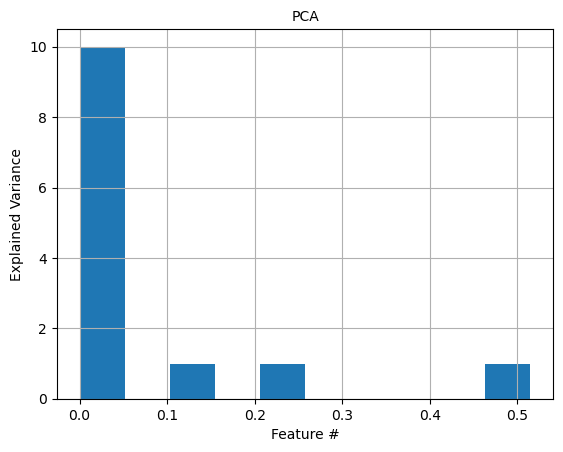

In [6]:
# PCA
from sklearn import preprocessing
from sklearn.decomposition import PCA

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

pca = PCA(n_components = 13)
pca.fit(X)

pca_evr = pd.DataFrame(pca.explained_variance_ratio_)

# Create a figure with two subplots
pca_evr.hist()
plt.title("PCA",fontsize=10)
plt.xlabel('Feature #',fontsize=10)
plt.ylabel('Explained Variance',fontsize=10)


In [7]:
# Baseline models
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

print(decision_tree.score(X_test, y_test))
print(random_forest.score(X_test, y_test))

0.5315101070154578
0.5963139120095124


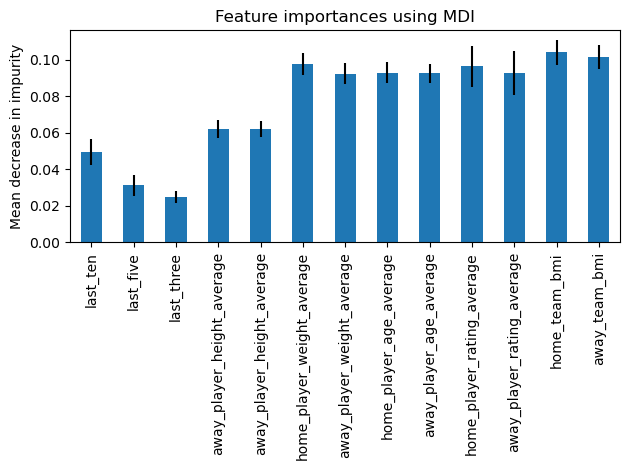

In [8]:
# Feature importance (RF) - based on mean decrease in impurity
importances = random_forest.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

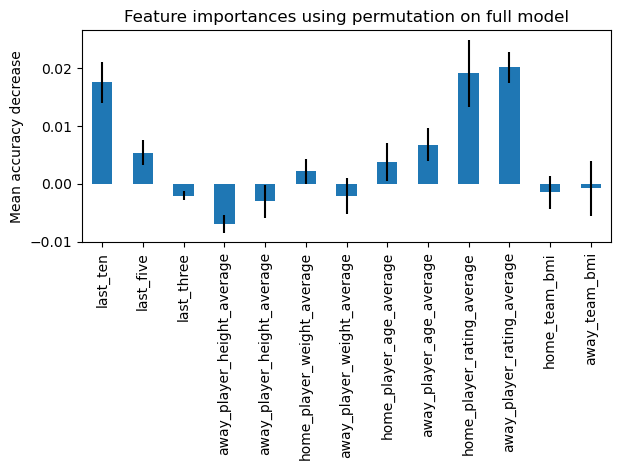

In [9]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    random_forest, X_test, y_test) # n_repeats=10, random_state=42, n_jobs=2

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [10]:
# Logistic regression
from sklearn import linear_model

logistic_regression = linear_model.LogisticRegression()
logistic_regression.fit(X_train, y_train)

print(logistic_regression.score(X_test, y_test))

0.6076099881093936


C:\Users\richt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gauss_nb = GaussianNB()
gauss_nb.fit(X_train, y_train)

print(gauss_nb.score(X_test, y_test))

0.6086008719778042


In [12]:
# K nearest neighbor
from sklearn.neighbors import KNeighborsClassifier

k_neighbors = KNeighborsClassifier()
k_neighbors.fit(X_train, y_train)

print(k_neighbors.score(X_test, y_test))

0.559056678557273


In [13]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier

ada_boost = AdaBoostClassifier(n_estimators = 200)
ada_boost.fit(X_train, y_train)

print(ada_boost.score(X_test, y_test))

0.6010701545778835


In [14]:
# Gradient Boost Classifier
from sklearn.ensemble import GradientBoostingClassifier

gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X_train, y_train)

print(gradient_boost.score(X_test, y_test))

0.6129607609988109


In [39]:
# Define the objective function
def objective(trial):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'random_state': 42
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [41]:
# Define the search space using IntLogUniformDistribution
search_space = {
    'num_leaves': optuna.distributions.IntLogUniformDistribution(2, 256),
    'learning_rate': optuna.distributions.LogUniformDistribution(0.001, 0.1),
    'max_depth': optuna.distributions.IntUniformDistribution(3, 10),
    'feature_fraction': optuna.distributions.UniformDistribution(0.1, 1.0),
    'bagging_fraction': optuna.distributions.UniformDistribution(0.1, 1.0),
    'bagging_freq': optuna.distributions.IntUniformDistribution(1, 10),
    'min_child_samples': optuna.distributions.IntUniformDistribution(5, 100),
}

# Create a study object and run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Train the final model with the best hyperparameters
best_params = study.best_params
model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_lgbm = accuracy_score(y_test, y_pred)

# Print the results
print('Best accuracy:', study.best_value)
print('Best parameters:', study.best_params)
print('Accuracy on test data:', accuracy)

[I 2023-04-17 16:21:54,499] A new study created in memory with name: no-name-b555ed88-e3e5-4f0d-868b-9f683a7f2cb8
[I 2023-04-17 16:21:54,613] Trial 0 finished with value: 0.5780816488307571 and parameters: {'num_leaves': 62, 'learning_rate': 0.004175462521872442, 'max_depth': 6, 'feature_fraction': 0.3434686311223459, 'bagging_fraction': 0.8614359717443965, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 0 with value: 0.5780816488307571.


[LightGBM] [Warning] feature_fraction is set=0.3434686311223459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3434686311223459
[LightGBM] [Warning] bagging_fraction is set=0.8614359717443965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8614359717443965
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6246678419230268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6246678419230268
[LightGBM] [Warning] bagging_fraction is set=0.7315113207436851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7315113207436851
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2023-04-17 16:21:54,743] Trial 1 finished with value: 0.6006738010305193 and parameters: {'num_leaves': 107, 'learning_rate': 0.0668064992165396, 'max_depth': 9, 'feature_fraction': 0.6246678419230268, 'bagging_fraction': 0.7315113207436851, 'bagging_freq': 5, 'min_child_samples': 94}. Best is trial 1 with value: 0.6006738010305193.
[I 2023-04-17 16:21:54,915] Trial 2 finished with value: 0.6078081648830757 and parameters: {'num_leaves': 143, 'learning_rate': 0.01259374711001932, 'max_depth': 8, 'feature_fraction': 0.8358751147801314, 'bagging_fraction': 0.8846639328371608, 'bagging_freq': 1, 'min_child_samples': 62}. Best is trial 2 with value: 0.6078081648830757.


[LightGBM] [Warning] feature_fraction is set=0.8358751147801314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8358751147801314
[LightGBM] [Warning] bagging_fraction is set=0.8846639328371608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8846639328371608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.852173945783684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.852173945783684
[LightGBM] [Warning] bagging_fraction is set=0.5322666248605565, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5322666248605565
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-17 16:21:55,142] Trial 3 finished with value: 0.5820451843043996 and parameters: {'num_leaves': 147, 'learning_rate': 0.08717040672116176, 'max_depth': 10, 'feature_fraction': 0.852173945783684, 'bagging_fraction': 0.5322666248605565, 'bagging_freq': 10, 'min_child_samples': 6}. Best is trial 2 with value: 0.6078081648830757.
[I 2023-04-17 16:21:55,270] Trial 4 finished with value: 0.6000792707094729 and parameters: {'num_leaves': 97, 'learning_rate': 0.07965319042851753, 'max_depth': 10, 'feature_fraction': 0.6390180858131904, 'bagging_fraction': 0.826497102772018, 'bagging_freq': 9, 'min_child_samples': 81}. Best is trial 2 with value: 0.6078081648830757.


[LightGBM] [Warning] feature_fraction is set=0.6390180858131904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6390180858131904
[LightGBM] [Warning] bagging_fraction is set=0.826497102772018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.826497102772018
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.6328012664442105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6328012664442105
[LightGBM] [Warning] bagging_fraction is set=0.6180632323844616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6180632323844616
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2023-04-17 16:21:55,515] Trial 5 finished with value: 0.6101862861672612 and parameters: {'num_leaves': 220, 'learning_rate': 0.016470697159022874, 'max_depth': 10, 'feature_fraction': 0.6328012664442105, 'bagging_fraction': 0.6180632323844616, 'bagging_freq': 10, 'min_child_samples': 32}. Best is trial 5 with value: 0.6101862861672612.
[I 2023-04-17 16:21:55,579] Trial 6 finished with value: 0.6032500990883869 and parameters: {'num_leaves': 143, 'learning_rate': 0.011507741779008445, 'max_depth': 3, 'feature_fraction': 0.8407012213632383, 'bagging_fraction': 0.8019299952842355, 'bagging_freq': 7, 'min_child_samples': 74}. Best is trial 5 with value: 0.6101862861672612.
[I 2023-04-17 16:21:55,649] Trial 7 finished with value: 0.6137534680935395 and parameters: {'num_leaves': 141, 'learning_rate': 0.06685317834924308, 'max_depth': 4, 'feature_fraction': 0.31703608550163054, 'bagging_fraction': 0.7555801279064228, 'bagging_freq': 8, 'min_child_samples': 52}. Best is trial 7 with value

[LightGBM] [Warning] feature_fraction is set=0.8407012213632383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8407012213632383
[LightGBM] [Warning] bagging_fraction is set=0.8019299952842355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8019299952842355
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.31703608550163054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31703608550163054
[LightGBM] [Warning] bagging_fraction is set=0.7555801279064228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7555801279064228
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.865666890519321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.865666890519321
[LightGBM] [Warning] bagging

[I 2023-04-17 16:21:55,764] Trial 9 finished with value: 0.5511296076099881 and parameters: {'num_leaves': 151, 'learning_rate': 0.0017824837836681237, 'max_depth': 3, 'feature_fraction': 0.991636683382932, 'bagging_fraction': 0.29105496729560965, 'bagging_freq': 2, 'min_child_samples': 99}. Best is trial 7 with value: 0.6137534680935395.
[I 2023-04-17 16:21:55,887] Trial 10 finished with value: 0.6058263971462544 and parameters: {'num_leaves': 32, 'learning_rate': 0.029799681704439678, 'max_depth': 5, 'feature_fraction': 0.18015464126240155, 'bagging_fraction': 0.9423654118886621, 'bagging_freq': 7, 'min_child_samples': 31}. Best is trial 7 with value: 0.6137534680935395.


[LightGBM] [Warning] feature_fraction is set=0.991636683382932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.991636683382932
[LightGBM] [Warning] bagging_fraction is set=0.29105496729560965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.29105496729560965
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.18015464126240155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18015464126240155
[LightGBM] [Warning] bagging_fraction is set=0.9423654118886621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9423654118886621
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2023-04-17 16:21:56,013] Trial 11 finished with value: 0.6129607609988109 and parameters: {'num_leaves': 244, 'learning_rate': 0.028251871684880636, 'max_depth': 5, 'feature_fraction': 0.4371179135622911, 'bagging_fraction': 0.6097044228779553, 'bagging_freq': 9, 'min_child_samples': 35}. Best is trial 7 with value: 0.6137534680935395.
[I 2023-04-17 16:21:56,147] Trial 12 finished with value: 0.6091954022988506 and parameters: {'num_leaves': 240, 'learning_rate': 0.03351615806196106, 'max_depth': 5, 'feature_fraction': 0.39084534462978293, 'bagging_fraction': 0.5669177262203681, 'bagging_freq': 8, 'min_child_samples': 50}. Best is trial 7 with value: 0.6137534680935395.


[LightGBM] [Warning] feature_fraction is set=0.4371179135622911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4371179135622911
[LightGBM] [Warning] bagging_fraction is set=0.6097044228779553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6097044228779553
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.39084534462978293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39084534462978293
[LightGBM] [Warning] bagging_fraction is set=0.5669177262203681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5669177262203681
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2023-04-17 16:21:56,283] Trial 13 finished with value: 0.6099881093935791 and parameters: {'num_leaves': 197, 'learning_rate': 0.03573003843114741, 'max_depth': 5, 'feature_fraction': 0.4238624801664428, 'bagging_fraction': 0.6779743012443641, 'bagging_freq': 8, 'min_child_samples': 28}. Best is trial 7 with value: 0.6137534680935395.


[LightGBM] [Warning] feature_fraction is set=0.4238624801664428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4238624801664428
[LightGBM] [Warning] bagging_fraction is set=0.6779743012443641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6779743012443641
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.12470893043092288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12470893043092288
[LightGBM] [Warning] bagging_fraction is set=0.4506412002830892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4506412002830892
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-17 16:21:56,437] Trial 14 finished with value: 0.5679746333729687 and parameters: {'num_leaves': 251, 'learning_rate': 0.005886114187754832, 'max_depth': 7, 'feature_fraction': 0.12470893043092288, 'bagging_fraction': 0.4506412002830892, 'bagging_freq': 3, 'min_child_samples': 64}. Best is trial 7 with value: 0.6137534680935395.
[I 2023-04-17 16:21:56,537] Trial 15 finished with value: 0.6103844629409433 and parameters: {'num_leaves': 198, 'learning_rate': 0.022237277748181676, 'max_depth': 4, 'feature_fraction': 0.2646045824770943, 'bagging_fraction': 0.9950002291933007, 'bagging_freq': 9, 'min_child_samples': 42}. Best is trial 7 with value: 0.6137534680935395.
[I 2023-04-17 16:21:56,627] Trial 16 finished with value: 0.6127625842251289 and parameters: {'num_leaves': 8, 'learning_rate': 0.05203848982610273, 'max_depth': 6, 'feature_fraction': 0.5024500044250543, 'bagging_fraction': 0.7242003795673753, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 7 with value:

[LightGBM] [Warning] feature_fraction is set=0.2646045824770943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2646045824770943
[LightGBM] [Warning] bagging_fraction is set=0.9950002291933007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9950002291933007
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.5024500044250543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5024500044250543
[LightGBM] [Warning] bagging_fraction is set=0.7242003795673753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7242003795673753
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.27075574513417944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27075574513417944
[LightGBM] [Warning] baggi

[I 2023-04-17 16:21:56,722] Trial 17 finished with value: 0.6147443519619501 and parameters: {'num_leaves': 79, 'learning_rate': 0.05217557001180573, 'max_depth': 4, 'feature_fraction': 0.27075574513417944, 'bagging_fraction': 0.4698958510647105, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 17 with value: 0.6147443519619501.
[I 2023-04-17 16:21:56,815] Trial 18 finished with value: 0.60820451843044 and parameters: {'num_leaves': 83, 'learning_rate': 0.04937889612670394, 'max_depth': 4, 'feature_fraction': 0.2677673825101535, 'bagging_fraction': 0.4046098033906796, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 17 with value: 0.6147443519619501.
[I 2023-04-17 16:21:56,906] Trial 19 finished with value: 0.6099881093935791 and parameters: {'num_leaves': 58, 'learning_rate': 0.09485707739482312, 'max_depth': 4, 'feature_fraction': 0.10539583826500537, 'bagging_fraction': 0.46512758431582246, 'bagging_freq': 3, 'min_child_samples': 78}. Best is trial 17 with value:

[LightGBM] [Warning] feature_fraction is set=0.2677673825101535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2677673825101535
[LightGBM] [Warning] bagging_fraction is set=0.4046098033906796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4046098033906796
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.10539583826500537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10539583826500537
[LightGBM] [Warning] bagging_fraction is set=0.46512758431582246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46512758431582246
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.24827347619512502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24827347619512502
[LightGBM] [Warning] b

[I 2023-04-17 16:21:57,031] Trial 20 finished with value: 0.6074118113357114 and parameters: {'num_leaves': 112, 'learning_rate': 0.05275723477869173, 'max_depth': 7, 'feature_fraction': 0.24827347619512502, 'bagging_fraction': 0.13616916790100675, 'bagging_freq': 6, 'min_child_samples': 55}. Best is trial 17 with value: 0.6147443519619501.
[I 2023-04-17 16:21:57,140] Trial 21 finished with value: 0.605033690051526 and parameters: {'num_leaves': 178, 'learning_rate': 0.019948740254145916, 'max_depth': 4, 'feature_fraction': 0.33809370810336636, 'bagging_fraction': 0.6329662349266842, 'bagging_freq': 8, 'min_child_samples': 40}. Best is trial 17 with value: 0.6147443519619501.
[I 2023-04-17 16:21:57,257] Trial 22 finished with value: 0.6121680539040825 and parameters: {'num_leaves': 75, 'learning_rate': 0.03742327134991441, 'max_depth': 5, 'feature_fraction': 0.4837530419111097, 'bagging_fraction': 0.5474086373349327, 'bagging_freq': 9, 'min_child_samples': 20}. Best is trial 17 with va

[LightGBM] [Warning] feature_fraction is set=0.33809370810336636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33809370810336636
[LightGBM] [Warning] bagging_fraction is set=0.6329662349266842, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6329662349266842
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.4837530419111097, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4837530419111097
[LightGBM] [Warning] bagging_fraction is set=0.5474086373349327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5474086373349327
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2023-04-17 16:21:57,407] Trial 23 finished with value: 0.6131589377724931 and parameters: {'num_leaves': 40, 'learning_rate': 0.06008054752201671, 'max_depth': 6, 'feature_fraction': 0.42931192903875437, 'bagging_fraction': 0.7603148824238026, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 17 with value: 0.6147443519619501.


[LightGBM] [Warning] feature_fraction is set=0.42931192903875437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42931192903875437
[LightGBM] [Warning] bagging_fraction is set=0.7603148824238026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7603148824238026
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.333129455070742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.333129455070742
[LightGBM] [Warning] bagging_fraction is set=0.7721832694375851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7721832694375851
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2023-04-17 16:21:57,545] Trial 24 finished with value: 0.606817281014665 and parameters: {'num_leaves': 42, 'learning_rate': 0.06563016912468168, 'max_depth': 6, 'feature_fraction': 0.333129455070742, 'bagging_fraction': 0.7721832694375851, 'bagging_freq': 4, 'min_child_samples': 70}. Best is trial 17 with value: 0.6147443519619501.
[I 2023-04-17 16:21:57,645] Trial 25 finished with value: 0.6086008719778042 and parameters: {'num_leaves': 11, 'learning_rate': 0.09269173077274588, 'max_depth': 7, 'feature_fraction': 0.20719600488284254, 'bagging_fraction': 0.6904403379879551, 'bagging_freq': 4, 'min_child_samples': 51}. Best is trial 17 with value: 0.6147443519619501.
[I 2023-04-17 16:21:57,745] Trial 26 finished with value: 0.6143479984145858 and parameters: {'num_leaves': 118, 'learning_rate': 0.04889355319170996, 'max_depth': 4, 'feature_fraction': 0.3011022167193719, 'bagging_fraction': 0.7772454231525073, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 17 with value: 

[LightGBM] [Warning] feature_fraction is set=0.20719600488284254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20719600488284254
[LightGBM] [Warning] bagging_fraction is set=0.6904403379879551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6904403379879551
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.3011022167193719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3011022167193719
[LightGBM] [Warning] bagging_fraction is set=0.7772454231525073, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7772454231525073
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.2133037984286169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2133037984286169
[LightGBM] [Warning] baggi

[I 2023-04-17 16:21:57,840] Trial 27 finished with value: 0.6131589377724931 and parameters: {'num_leaves': 125, 'learning_rate': 0.04109629476485255, 'max_depth': 3, 'feature_fraction': 0.2133037984286169, 'bagging_fraction': 0.9067312994350096, 'bagging_freq': 1, 'min_child_samples': 84}. Best is trial 17 with value: 0.6147443519619501.
[I 2023-04-17 16:21:57,943] Trial 28 finished with value: 0.6087990487514863 and parameters: {'num_leaves': 126, 'learning_rate': 0.025480937256426084, 'max_depth': 4, 'feature_fraction': 0.3057990837744645, 'bagging_fraction': 0.8137688057512327, 'bagging_freq': 3, 'min_child_samples': 66}. Best is trial 17 with value: 0.6147443519619501.
[I 2023-04-17 16:21:58,056] Trial 29 finished with value: 0.6133571145461751 and parameters: {'num_leaves': 91, 'learning_rate': 0.041667766289741864, 'max_depth': 4, 'feature_fraction': 0.3681144169114054, 'bagging_fraction': 0.8557377328810811, 'bagging_freq': 2, 'min_child_samples': 47}. Best is trial 17 with val

[LightGBM] [Warning] feature_fraction is set=0.3057990837744645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3057990837744645
[LightGBM] [Warning] bagging_fraction is set=0.8137688057512327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8137688057512327
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.3681144169114054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3681144169114054
[LightGBM] [Warning] bagging_fraction is set=0.8557377328810811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8557377328810811
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-17 16:21:58,147] Trial 30 finished with value: 0.5982956797463337 and parameters: {'num_leaves': 67, 'learning_rate': 0.008493521315648409, 'max_depth': 3, 'feature_fraction': 0.30708980801844366, 'bagging_fraction': 0.672156047114002, 'bagging_freq': 5, 'min_child_samples': 58}. Best is trial 17 with value: 0.6147443519619501.
[I 2023-04-17 16:21:58,261] Trial 31 finished with value: 0.6133571145461751 and parameters: {'num_leaves': 92, 'learning_rate': 0.043260467235404026, 'max_depth': 4, 'feature_fraction': 0.3792232790951508, 'bagging_fraction': 0.8552274312320218, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 17 with value: 0.6147443519619501.


[LightGBM] [Warning] feature_fraction is set=0.30708980801844366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30708980801844366
[LightGBM] [Warning] bagging_fraction is set=0.672156047114002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.672156047114002
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.3792232790951508, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3792232790951508
[LightGBM] [Warning] bagging_fraction is set=0.8552274312320218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8552274312320218
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.36625552449255183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36625552449255183
[LightGBM] [Warning] baggi

[I 2023-04-17 16:21:58,373] Trial 32 finished with value: 0.6101862861672612 and parameters: {'num_leaves': 111, 'learning_rate': 0.06669705677091615, 'max_depth': 4, 'feature_fraction': 0.36625552449255183, 'bagging_fraction': 0.74054083484394, 'bagging_freq': 2, 'min_child_samples': 46}. Best is trial 17 with value: 0.6147443519619501.
[I 2023-04-17 16:21:58,487] Trial 33 finished with value: 0.6117717003567182 and parameters: {'num_leaves': 98, 'learning_rate': 0.06673478316325296, 'max_depth': 5, 'feature_fraction': 0.28275030069472995, 'bagging_fraction': 0.8433536623511076, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 17 with value: 0.6147443519619501.


[LightGBM] [Warning] feature_fraction is set=0.28275030069472995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28275030069472995
[LightGBM] [Warning] bagging_fraction is set=0.8433536623511076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8433536623511076
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.19161545000879726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19161545000879726
[LightGBM] [Warning] bagging_fraction is set=0.9320670352746916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9320670352746916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-17 16:21:58,650] Trial 34 finished with value: 0.6074118113357114 and parameters: {'num_leaves': 58, 'learning_rate': 0.046312716000015464, 'max_depth': 8, 'feature_fraction': 0.19161545000879726, 'bagging_fraction': 0.9320670352746916, 'bagging_freq': 1, 'min_child_samples': 38}. Best is trial 17 with value: 0.6147443519619501.
[I 2023-04-17 16:21:58,747] Trial 35 finished with value: 0.6133571145461751 and parameters: {'num_leaves': 134, 'learning_rate': 0.09899289192915048, 'max_depth': 3, 'feature_fraction': 0.3557017457306499, 'bagging_fraction': 0.8719357128254407, 'bagging_freq': 5, 'min_child_samples': 68}. Best is trial 17 with value: 0.6147443519619501.
[I 2023-04-17 16:21:58,854] Trial 36 finished with value: 0.6054300435988902 and parameters: {'num_leaves': 114, 'learning_rate': 0.016911042087397417, 'max_depth': 4, 'feature_fraction': 0.24352667406640854, 'bagging_fraction': 0.8014639997541047, 'bagging_freq': 2, 'min_child_samples': 58}. Best is trial 17 with v

[LightGBM] [Warning] feature_fraction is set=0.3557017457306499, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3557017457306499
[LightGBM] [Warning] bagging_fraction is set=0.8719357128254407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8719357128254407
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.24352667406640854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24352667406640854
[LightGBM] [Warning] bagging_fraction is set=0.8014639997541047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8014639997541047
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-17 16:21:58,970] Trial 37 finished with value: 0.6052318668252081 and parameters: {'num_leaves': 156, 'learning_rate': 0.03064467977763122, 'max_depth': 5, 'feature_fraction': 0.15835718283587896, 'bagging_fraction': 0.8836081339386046, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 17 with value: 0.6147443519619501.
[I 2023-04-17 16:21:59,093] Trial 38 finished with value: 0.6078081648830757 and parameters: {'num_leaves': 87, 'learning_rate': 0.07541863942361136, 'max_depth': 6, 'feature_fraction': 0.5715715583457501, 'bagging_fraction': 0.7245655722517939, 'bagging_freq': 3, 'min_child_samples': 85}. Best is trial 17 with value: 0.6147443519619501.


[LightGBM] [Warning] feature_fraction is set=0.15835718283587896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15835718283587896
[LightGBM] [Warning] bagging_fraction is set=0.8836081339386046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8836081339386046
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5715715583457501, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5715715583457501
[LightGBM] [Warning] bagging_fraction is set=0.7245655722517939, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7245655722517939
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2023-04-17 16:21:59,191] Trial 39 finished with value: 0.6165279429250892 and parameters: {'num_leaves': 167, 'learning_rate': 0.057038473191661686, 'max_depth': 3, 'feature_fraction': 0.3079625645789093, 'bagging_fraction': 0.7701756061637217, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 39 with value: 0.6165279429250892.
[I 2023-04-17 16:21:59,284] Trial 40 finished with value: 0.6143479984145858 and parameters: {'num_leaves': 171, 'learning_rate': 0.07702032631468343, 'max_depth': 3, 'feature_fraction': 0.15684717307304064, 'bagging_fraction': 0.7789926462365001, 'bagging_freq': 1, 'min_child_samples': 72}. Best is trial 39 with value: 0.6165279429250892.


[LightGBM] [Warning] feature_fraction is set=0.3079625645789093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3079625645789093
[LightGBM] [Warning] bagging_fraction is set=0.7701756061637217, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7701756061637217
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.15684717307304064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15684717307304064
[LightGBM] [Warning] bagging_fraction is set=0.7789926462365001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7789926462365001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-04-17 16:21:59,449] Trial 41 finished with value: 0.6155370590566785 and parameters: {'num_leaves': 171, 'learning_rate': 0.07666411755595326, 'max_depth': 3, 'feature_fraction': 0.1323629690598351, 'bagging_fraction': 0.7517860832883633, 'bagging_freq': 1, 'min_child_samples': 75}. Best is trial 39 with value: 0.6165279429250892.
[I 2023-04-17 16:21:59,541] Trial 42 finished with value: 0.6173206500198177 and parameters: {'num_leaves': 186, 'learning_rate': 0.07930628602145717, 'max_depth': 3, 'feature_fraction': 0.14778809199859932, 'bagging_fraction': 0.7860348078338006, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 42 with value: 0.6173206500198177.


[LightGBM] [Warning] feature_fraction is set=0.1323629690598351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1323629690598351
[LightGBM] [Warning] bagging_fraction is set=0.7517860832883633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7517860832883633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.14778809199859932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14778809199859932
[LightGBM] [Warning] bagging_fraction is set=0.7860348078338006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860348078338006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1035648804999178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1035648804999178
[LightGBM] [Warning] baggi

[I 2023-04-17 16:21:59,641] Trial 43 finished with value: 0.6087990487514863 and parameters: {'num_leaves': 186, 'learning_rate': 0.05497766913815929, 'max_depth': 3, 'feature_fraction': 0.1035648804999178, 'bagging_fraction': 0.8027965168731686, 'bagging_freq': 1, 'min_child_samples': 90}. Best is trial 42 with value: 0.6173206500198177.
[I 2023-04-17 16:21:59,735] Trial 44 finished with value: 0.6155370590566785 and parameters: {'num_leaves': 216, 'learning_rate': 0.08112647350020412, 'max_depth': 3, 'feature_fraction': 0.14129811779529255, 'bagging_fraction': 0.7147564966550024, 'bagging_freq': 1, 'min_child_samples': 97}. Best is trial 42 with value: 0.6173206500198177.
[I 2023-04-17 16:21:59,828] Trial 45 finished with value: 0.6147443519619501 and parameters: {'num_leaves': 221, 'learning_rate': 0.0785470435668739, 'max_depth': 3, 'feature_fraction': 0.1514108294449459, 'bagging_fraction': 0.6438140252549325, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 42 with val

[LightGBM] [Warning] feature_fraction is set=0.14129811779529255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14129811779529255
[LightGBM] [Warning] bagging_fraction is set=0.7147564966550024, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7147564966550024
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.1514108294449459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1514108294449459
[LightGBM] [Warning] bagging_fraction is set=0.6438140252549325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6438140252549325
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.21908051771654924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21908051771654924
[LightGBM] [Warning] bag

[I 2023-04-17 16:21:59,926] Trial 46 finished with value: 0.6099881093935791 and parameters: {'num_leaves': 218, 'learning_rate': 0.09610513426731943, 'max_depth': 3, 'feature_fraction': 0.21908051771654924, 'bagging_fraction': 0.7131984144001287, 'bagging_freq': 2, 'min_child_samples': 95}. Best is trial 42 with value: 0.6173206500198177.
[I 2023-04-17 16:22:00,021] Trial 47 finished with value: 0.6064209274673008 and parameters: {'num_leaves': 203, 'learning_rate': 0.05898175964229789, 'max_depth': 3, 'feature_fraction': 0.13648921315927315, 'bagging_fraction': 0.6019810092555611, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 42 with value: 0.6173206500198177.
[I 2023-04-17 16:22:00,182] Trial 48 finished with value: 0.5941339674990092 and parameters: {'num_leaves': 160, 'learning_rate': 0.07900712084261076, 'max_depth': 9, 'feature_fraction': 0.18118307257168115, 'bagging_fraction': 0.6776103410675544, 'bagging_freq': 2, 'min_child_samples': 77}. Best is trial 42 with v

[LightGBM] [Warning] feature_fraction is set=0.13648921315927315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13648921315927315
[LightGBM] [Warning] bagging_fraction is set=0.6019810092555611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6019810092555611
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.18118307257168115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.18118307257168115
[LightGBM] [Warning] bagging_fraction is set=0.6776103410675544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6776103410675544
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2023-04-17 16:22:00,281] Trial 49 finished with value: 0.6107808164883076 and parameters: {'num_leaves': 186, 'learning_rate': 0.034971983436623263, 'max_depth': 3, 'feature_fraction': 0.2314087298230955, 'bagging_fraction': 0.8312153920774656, 'bagging_freq': 1, 'min_child_samples': 86}. Best is trial 42 with value: 0.6173206500198177.


[LightGBM] [Warning] feature_fraction is set=0.2314087298230955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2314087298230955
[LightGBM] [Warning] bagging_fraction is set=0.8312153920774656, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312153920774656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.14778809199859932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14778809199859932
[LightGBM] [Warning] bagging_fraction is set=0.7860348078338006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860348078338006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Best accuracy: 0.6173206500198177
Best parameters: {'num_leaves': 186, 'learning_rate': 0.07930628602145717, 'max_depth': 3, 'feature_fraction': 0.14778809199859932, 'bagging_fract

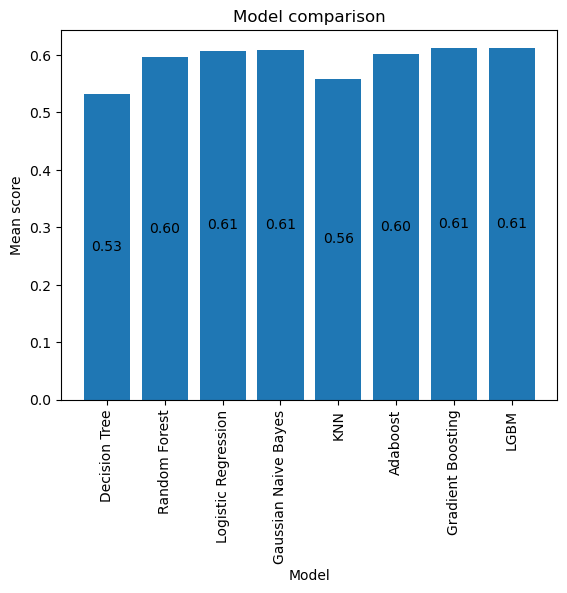

In [42]:
# Comparison of Models
model_names = ['Decision Tree', 'Random Forest', 'Logistic Regression', 'Gaussian Naive Bayes', 'KNN', 
               "Adaboost", "Gradient Boosting","LGBM"]
scores = [decision_tree.score(X_test, y_test), random_forest.score(X_test, y_test), logistic_regression.score(X_test, y_test), 
          gauss_nb.score(X_test, y_test),k_neighbors.score(X_test, y_test),ada_boost.score(X_test, y_test),
          gradient_boost.score(X_test, y_test),accuracy_lgbm]

# Create a bar chart
plt.bar(model_names, scores)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Mean score')
plt.title('Model comparison')

# Display the graph
for i in range(len(model_names)):
    plt.text(i, scores[i]/2, '{:.2f}'.format(scores[i]), ha='center', va='center')
plt.xticks(rotation=90)
plt.show()